# plot_cross_sections.ipynb

Author: Savannah J. Southward and Robert M. Frost

University of Oklahoma

Created 02 November 2023

Purpose: Plot vertical cross sections of reflectivity through supercell updrafts

In [103]:
import numpy as np
import xarray as xr
import pyart
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from capstone_utils import geographic_to_cartesian_aeqd
import os

In [104]:
track_point = 10
elec = "nonlightning"
meso_id = "201708-058"

dth = f"/Users/robertfrost/Documents/boomsoon/2023_semester_2/capstone/analysis/Capstone_2023/data/{elec}_cases/timeheight_{meso_id}.nc"
figdir = f"/Users/robertfrost/Documents/boomsoon/2023_semester_2/capstone/analysis/figures/{elec}_cases/{meso_id}/"
dnc = f"/Users/robertfrost/Documents/boomsoon/2023_semester_2/capstone/analysis/capstone_2023.nc"
drad = f"/Users/robertfrost/Documents/boomsoon/2023_semester_2/capstone/analysis/Capstone_2023/data/{elec}_cases/{meso_id}/"

In [105]:
# list of files in drad and sort
files = os.listdir(drad)
sorted_files = sorted(files)

# open desired radar file
radar = pyart.io.read(f"{drad}{sorted_files[track_point]}")

# extract radar position
radar_lat = radar.latitude['data'][0]
radar_lon = radar.longitude['data'][0]

# mask out last 10 gates of each ray, this removes the "ring" around the radar.
radar.fields["reflectivity"]["data"][:, -10:] = np.ma.masked

# exclude masked gates from the gridding
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_transition()
gatefilter.exclude_masked("reflectivity")

# grid data to cartesian format
grid = pyart.map.grid_from_radars(
    (radar,),
    gatefilters=(gatefilter,),
    grid_shape=(1, 300, 300),
    grid_limits=((2000, 2000), (-150000.0, 150000.0), (-150000.0, 150000.0)),
    fields=["reflectivity", "velocity"],
)

In [106]:
# open tracking dataset
meso_ds = xr.open_dataset(dnc)

# extract mesocyclone case and convert longitude
case_meso = meso_ds.where(meso_ds.mesocyclone_id == meso_id, drop=True)
case_meso["mesocyclone_longitude"] = case_meso.mesocyclone_longitude - 360

# extract mesocyclone location
meso_lat = float(case_meso.mesocyclone_latitude[track_point])
meso_lon = float(case_meso.mesocyclone_longitude[track_point])

# return meso location in x and y position relative to radar
meso_x, meso_y = geographic_to_cartesian_aeqd(meso_lon, meso_lat, radar_lon, radar_lat)

# calculate meso distance from radar
meso_dis = (meso_x ** 2 + meso_y **2) ** (1/2)

# calculate azimuth where meso lies
az = np.degrees(np.arctan2(meso_x, meso_y))
if az < 0:
    az = int(360 + az)

/var/folders/yn/ywyz24r54d7gz30gh63k_qvc0000gn/T/ipykernel_89480/2227094015.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  az = int(360 + az)


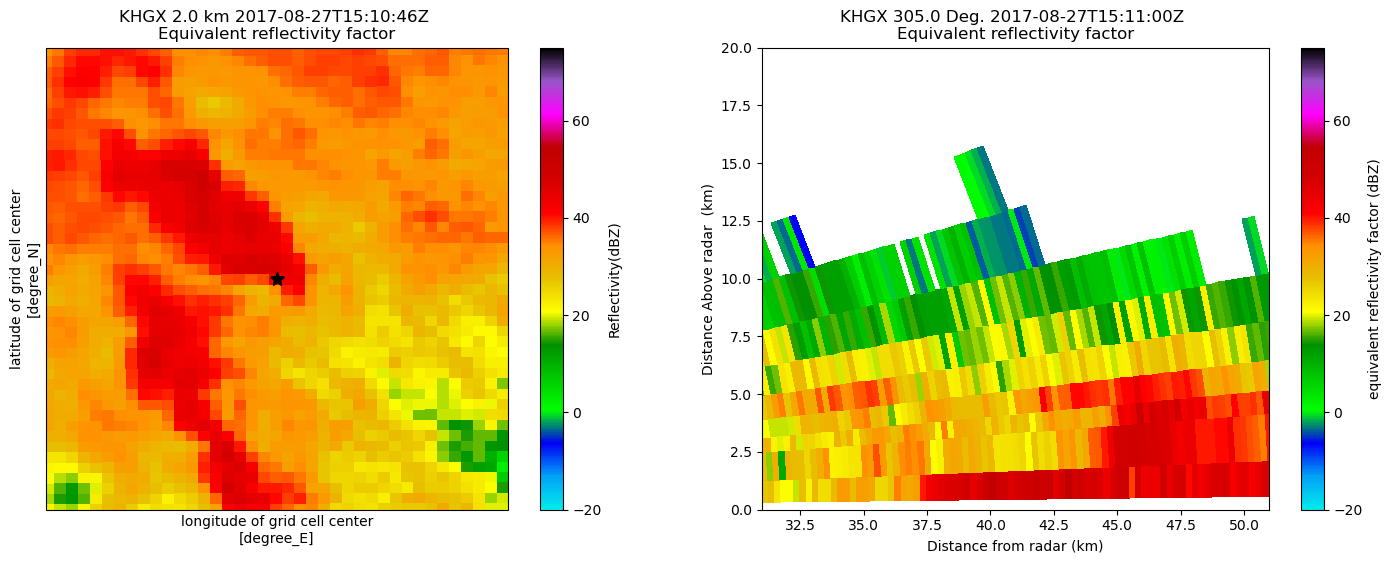

In [107]:
# spatial bounds (lat/lon) for plotting
del_deg = 0.2
lon_min = meso_lon - del_deg
lon_max = meso_lon + del_deg
lat_min = meso_lat - del_deg
lat_max = meso_lat + del_deg

# Setup the figure, and plot our x/y view of the radar
fig = plt.figure(figsize=(18, 6))
ax1 = plt.subplot(121, projection=ccrs.PlateCarree())
display = pyart.graph.GridMapDisplay(grid)
display.plot_grid(
    "reflectivity",
    ax=ax1,
    cmap="pyart_NWSRef",
    vmin=-20,
    vmax=75
)
# zoom in on mesocyclone
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
# mark center of mesocyclone
ax1.plot(meso_lon, meso_lat, marker='*', markersize=10, color='black')

# Add a cross section, using our start and end points, and set our x-axis as latitude (lat)
ax2 = plt.subplot(122)
ax2.set_ylim([0,20])
ax2.set_xlim([meso_dis/1000 - 10, meso_dis/1000 + 10])
xsect = pyart.util.cross_section_ppi(radar,[az])
display = pyart.graph.RadarDisplay(xsect)
display.plot(
    "reflectivity",
    cmap="pyart_NWSRef",
    vmin=-20,
    vmax=75) 

# save figure
plt.savefig(f"{figdir}{sorted_files[track_point]}_reflectivity_cross_section.png")

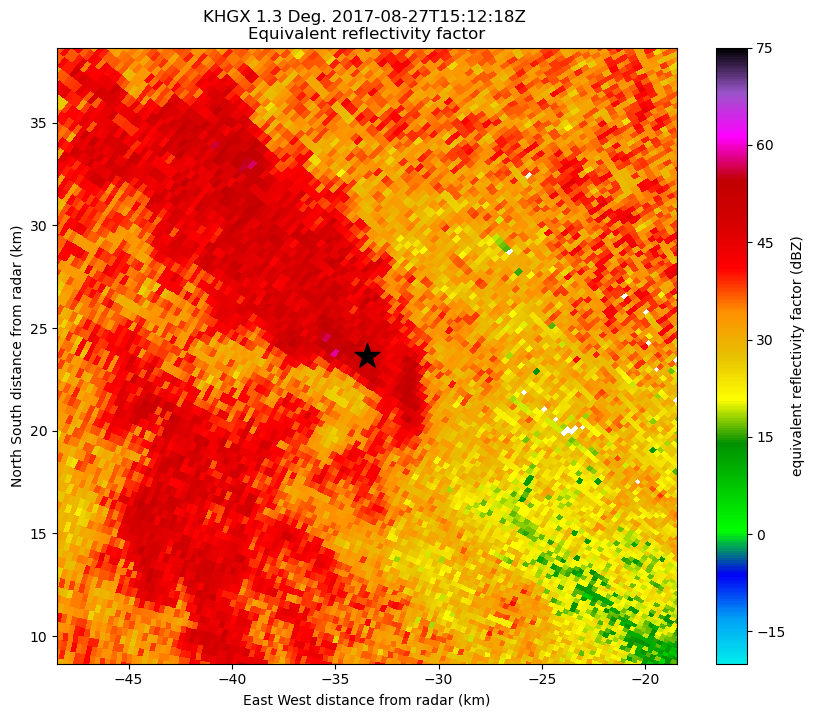

In [108]:
# spatial bounds (m) for plotting
del_m = 15
x_min = meso_x/1000 - del_m
x_max = meso_x/1000 + del_m
y_min = meso_y/1000 - del_m
y_max = meso_y/1000 + del_m

# variable to plot
var = "reflectivity"

# display object
display = pyart.graph.RadarDisplay(radar)
# create figure
fig = plt.figure(figsize=(10, 8))

# Plot reflectivity field (for example)
display.plot_ppi(var, sweep=5, vmin=-20, vmax=75, cmap='pyart_NWSRef')

# zoom in on mesocyclone
display.set_limits(xlim=(x_min, x_max), ylim=(y_min, y_max))
# Add a star marker at the specified point
plt.scatter(meso_x/1000, meso_y/1000, marker='*', c='black', s=350)

# Set colorbar ticks
cbar = display.cbs[-1]  # Get the colorbar associated with the last plot
ticks = np.arange(-15,75.1,15) # Specify your desired tick locations
tick_labels = ['-20', '0', '20', '40', '60', '75']  # Specify labels for the ticks
cbar.set_ticks(ticks)
# cbar.set_ticklabels(tick_labels)

# save out
plt.savefig(f"{figdir}{sorted_files[track_point]}_{var}_ppi.png", dpi=300, bbox_inches="tight")

In [109]:
# from capstone_utils import make_gif
# make_gif(figdir, f"{figdir}reflectivity_cross_section.gif")